In [1]:
import boto3
import cv2
import face_recognition
import matplotlib.pyplot as plt
import re

c:\Users\victor.nunes\Personal Projects\Cognitive Environments\CognitiveEnvironments\.venv\Lib\site-packages\face_recognition_models\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


Caminho para a imagem

In [2]:
caminho_imagem = './imagens/cnh-victor.jpg'

Carregar imagem (BGR padrão OpenCV)

In [3]:

imagem_bgr = cv2.imread(caminho_imagem)

Verifica se carregou corretamente

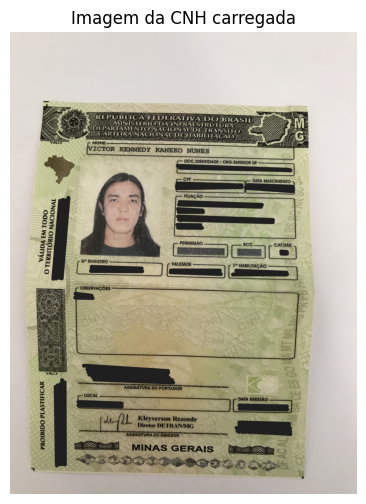

In [4]:
if imagem_bgr is None:
    print("Erro ao carregar a imagem.")
else:
    # Converte para RGB (correta para exibição com matplotlib)
    imagem_rgb = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2RGB)

    # Exibe a imagem
    plt.figure(figsize=(10, 6))
    plt.imshow(imagem_rgb)
    plt.axis('off')
    plt.title("Imagem da CNH carregada")
    plt.show() 

Cria o cliente AWS Textract com a região definida


In [5]:
textract = boto3.client('textract', region_name='us-east-1')

Lê a imagem como bytes

In [6]:
with open(caminho_imagem, 'rb') as img_file:
    bytes_imagem = img_file.read()

Faz a chamada para Textract

In [7]:
resposta = textract.detect_document_text(Document={'Bytes': bytes_imagem})

Mostra os blocos de texto extraídos

In [8]:
print("Texto extraído da imagem:")
print("=" * 40)
for bloco in resposta['Blocks']:
    if bloco['BlockType'] == 'LINE':
        print(bloco['Text'])

Texto extraído da imagem:
REPUBLICA FEDERATIVA DOKBRASI
MINISTERION DA INFRAESTRUTURA
CDEPARTAMENTONNACIONALDESTRANSITO
CARTEIRANACIONAL DEHABILITACAO
C
VALIS
NOME
VICTOR KENNEDY KANEKO NUNES
DOC.IDENTIDADE / ORG.EMISSOR UF
CPF
DATA NASCIMENTO
FILIAÇÃO
TODO
registered
PERMISSÃO
ACC
CAT.HAB
N° REGISTRO
VALIDADE
1a HABILITAÇÃO
OBSERVAÇÕES
VALID
ASSINATURA DO PORTADOR
EXPIRES
LOCAL
DATA EMISSÃO
depth
Kleyverson Rezende
Diretor DETRAN/MG
ASSINATURA DO EMISSOR
MINAS GERAIS


In [9]:
for i, bloco in enumerate(resposta['Blocks']):
    if bloco['BlockType'] == 'LINE':
        print(f"[{i}] {bloco['Text']}")

[1] REPUBLICA FEDERATIVA DOKBRASI
[2] MINISTERION DA INFRAESTRUTURA
[3] CDEPARTAMENTONNACIONALDESTRANSITO
[4] CARTEIRANACIONAL DEHABILITACAO
[5] C
[6] VALIS
[7] NOME
[8] VICTOR KENNEDY KANEKO NUNES
[9] DOC.IDENTIDADE / ORG.EMISSOR UF
[10] CPF
[11] DATA NASCIMENTO
[12] FILIAÇÃO
[13] TODO
[14] registered
[15] PERMISSÃO
[16] ACC
[17] CAT.HAB
[18] N° REGISTRO
[19] VALIDADE
[20] 1a HABILITAÇÃO
[21] OBSERVAÇÕES
[22] VALID
[23] ASSINATURA DO PORTADOR
[24] EXPIRES
[25] LOCAL
[26] DATA EMISSÃO
[27] depth
[28] Kleyverson Rezende
[29] Diretor DETRAN/MG
[30] ASSINATURA DO EMISSOR
[31] MINAS GERAIS


In [10]:
def extrair_valor_por_chave(resposta_textract, chave, offset=1):
    """
    Busca um campo por chave (ex: 'NOME', 'CPF') e retorna o valor 'offset' linhas abaixo.
    """
    blocos = [b for b in resposta_textract['Blocks'] if b['BlockType'] == 'LINE']
    for i, bloco in enumerate(blocos):
        if chave.upper() in bloco['Text'].upper():
            if i + offset < len(blocos):
                return blocos[i + offset]['Text']
    return None

Usando a função para extrair dados

In [11]:
def extrair_nome_por_heuristica(resposta_textract):
    blocos = [b['Text'] for b in resposta_textract['Blocks'] if b['BlockType'] == 'LINE']
    nome_candidato = None
    for i, texto in enumerate(blocos):
        if 'NOME' in texto.upper():
            for j in range(i+1, min(i+4, len(blocos))):
                candidato = blocos[j].strip()
                # Heurística: tudo maiúsculo, sem número e pelo menos duas palavras
                if (
                    candidato.isupper()
                    and not any(char.isdigit() for char in candidato)
                    and len(candidato.split()) >= 2
                    and len(candidato) > 15
                ):
                    nome_candidato = candidato
                    break
    return nome_candidato



In [12]:


# Junta todo o texto em uma string
linhas = [b['Text'] for b in resposta['Blocks'] if b['BlockType'] == 'LINE']
texto_unificado = ' '.join(linhas)

# Expressões regulares
regex_cpf = r'\d{3}.\d{3}.\d{3}-\d{2}'
regex_data = r'\d{2}/\d{2}/\d{4}'

# Busca
cpf_match = re.search(regex_cpf, texto_unificado)
data_match = re.search(regex_data, texto_unificado)

# Resultado final
cpf = cpf_match.group(0) if cpf_match else None
data_nasc = data_match.group(0) if data_match else None
nome_cnh = extrair_nome_por_heuristica(resposta)

print(f"Nome: {nome_cnh}")
print(f"CPF: {cpf}")
print(f"Data de Nascimento: {data_nasc}")

Nome: VICTOR KENNEDY KANEKO NUNES
CPF: None
Data de Nascimento: None


Número de faces detectadas: 1


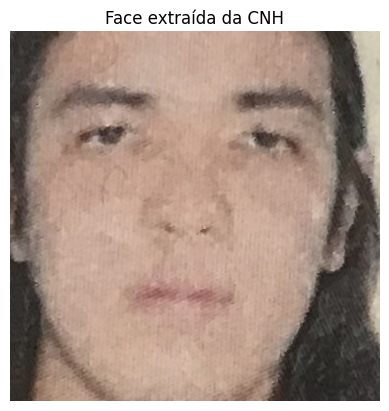

Face salva em: ./face_extraction/face_cnh.jpg


In [13]:
# Recarregar a imagem original
imagem_bgr = cv2.imread(caminho_imagem)
imagem_rgb = cv2.cvtColor(imagem_bgr, cv2.COLOR_BGR2RGB)

# Detectar localização de faces
faces = face_recognition.face_locations(imagem_rgb)

print(f"Número de faces detectadas: {len(faces)}")

# Se alguma face for encontrada, recorta a primeira
if faces:
    top, right, bottom, left = faces[0]
    face_recortada = imagem_rgb[top:bottom, left:right]

    # Exibir a face
    plt.imshow(face_recortada)
    plt.axis('off')
    plt.title('Face extraída da CNH')
    plt.show()

    # Salvar como imagem
    caminho_saida = './face_extraction/face_cnh.jpg'
    cv2.imwrite(caminho_saida, cv2.cvtColor(face_recortada, cv2.COLOR_RGB2BGR))
    print(f"Face salva em: {caminho_saida}")
else:
    print("Nenhuma face encontrada na imagem.")

In [14]:
# Carrega as duas imagens (em escala de cinza)
img1 = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./imagens/michel-1.jpg', cv2.IMREAD_GRAYSCALE)

# Verifica se ambas foram carregadas
if img1 is None or img2 is None:
    raise ValueError("Erro ao carregar as imagens de face.")

# Inicializa o ORB detector
orb = cv2.ORB_create()

# Detecta keypoints e descritores
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Compara com Brute-Force Hamming
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)

# Ordena os matches por distância (menor = melhor)
matches = sorted(matches, key=lambda x: x.distance)

# Calcula uma "pontuação de similaridade"
similaridade = 100 * (1 - sum([m.distance for m in matches[:10]]) / (10 * 256))
similaridade = max(0, min(100, similaridade))  # Clamp entre 0 e 100

print(f"Similaridade facial (via ORB): {similaridade:.2f}%")

# Exibe as correspondências visuais (opcional)
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, matches[:10], None, flags=2)
cv2.imwrite('./correspondencias_visuais/matches_orb.jpg', img_matches)
print("Imagem de comparação salva em: ./correspondencias_visuais/matches_orb.jpg")

Similaridade facial (via ORB): 78.67%
Imagem de comparação salva em: ./correspondencias_visuais/matches_orb.jpg


In [15]:
#  Função de pré-processamento
def preprocess_face(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        raise ValueError(f"Erro ao carregar: {img_path}")

# Redimensiona para tamanho fixo
    img = cv2.resize(img, (300, 300))

# Filtro bilateral para suavizar sem perder bordas
    img = cv2.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

# Equalização de histograma (contraste)
    img = cv2.equalizeHist(img)

    return img

In [16]:
# Pré-processamento das duas imagens
img1 = cv2.imread(caminho_imagem, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('./imagens/michel-2.jpg', cv2.IMREAD_GRAYSCALE)

# ORB
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(img1, None)
kp2, des2 = orb.detectAndCompute(img2, None)

# Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Similaridade com os 10 melhores matches
similaridade = 100 * (1 - sum([m.distance for m in matches[:10]]) / (10 * 256))
similaridade = max(0, min(100, similaridade))

# Exibir resultado
print(f"Similaridade facial (após pré-processamento): {similaridade:.2f}%")

# Decisão
if similaridade >= 90:
    decisao = "✅ Aprovado: identidade validada automaticamente."
elif 70 <= similaridade < 90:
    decisao = "⚠️ Alerta: semelhança insuficiente, requer validação manual."
else:
    decisao = "❌ Reprovado: possível fraude ou imagem inválida."

print(decisao)

Similaridade facial (após pré-processamento): 81.52%
⚠️ Alerta: semelhança insuficiente, requer validação manual.


In [17]:
# Cria o cliente Rekognition
rekognition = boto3.client('rekognition', region_name='us-east-1')

# Carrega imagens como bytes
with open(caminho_imagem, 'rb') as img_cnh:
    cnh_bytes = img_cnh.read()

with open('./imagens/convite-formatura-victor.jpg', 'rb') as img_selfie:
    selfie_bytes = img_selfie.read()

# Envia para AWS Rekognition
resposta = rekognition.compare_faces(
    SourceImage={'Bytes': cnh_bytes},
    TargetImage={'Bytes': selfie_bytes},
    SimilarityThreshold=70  # mínimo para considerar match
)

# Processa resposta
if resposta['FaceMatches']:
    similaridade = resposta['FaceMatches'][0]['Similarity']
    print(f"Similaridade (AWS Rekognition): {similaridade:.2f}%")
    if similaridade >= 90:
        print("Aprovado: identidade validada automaticamente.")
    else:
        print("⚠️ Alerta: semelhança insuficiente, requer validação manual.")
else:
    print("❌ Nenhuma correspondência detectada. Reprovar.")

Similaridade (AWS Rekognition): 99.90%
Aprovado: identidade validada automaticamente.


In [18]:
# Cria cliente Textract
textract = boto3.client('textract', region_name='us-east-1')

# Lê o comprovante
with open('./imagens/conta-mock.jpeg', 'rb') as doc:
    bytes_img = doc.read()

# Extração de texto
resposta = textract.detect_document_text(Document={'Bytes': bytes_img})

# Junta linhas
linhas = [b['Text'] for b in resposta['Blocks'] if b['BlockType'] == 'LINE']
texto_completo = '\n'.join(linhas)

print("Texto extraído:")
print("=" * 40)
print(texto_completo)

Texto extraído:
Comunicado
FAC
Importante
9912275104-SE/SPM
e
ITAU UNIBANCO S.A
Devolução
L Correios
Eletrônica
Correios
CTCE BELO HORIZONTE MG PL5
VICTOR KENNEDY KANEKO NUNES
AVENIDA SEBASTIAO DAYRELL DE L 110 AP 303
BRASILEIA
32600-266 BETIM MG
00 76969002 96303 00000016594 31 110325


In [19]:
# Localiza índice da linha que contém o CTCE (base para nome)
idx_ctce = next((i for i, l in enumerate(linhas) if "CTCE" in l), None)

nome_linha = None
if idx_ctce is not None and idx_ctce + 1 < len(linhas):
    nome_linha = linhas[idx_ctce + 1].strip()

# Localiza a linha que contém o CEP + cidade + UF
regex_cep = r'\d{5}-\d{3}\s+[A-Z]{2}'
idx_cep = next((i for i, l in enumerate(linhas) if re.search(regex_cep, l)), None)

endereco_linha = None
if idx_cep is not None and idx_cep - 2 >= 0:
    endereco_linha = linhas[idx_cep - 2].strip()
    endereco_linha1 = linhas[idx_cep - 1].strip()
    endereco_linha2 = linhas[idx_cep].strip()

print(f"Nome detectado no comprovante: {nome_linha}")
print(f"Endereço detectado: {endereco_linha}")
print(f"Bairro detectado: {endereco_linha1}")
print(f"Endereço detectado: {endereco_linha2}")

Nome detectado no comprovante: VICTOR KENNEDY KANEKO NUNES
Endereço detectado: AVENIDA SEBASTIAO DAYRELL DE L 110 AP 303
Bairro detectado: BRASILEIA
Endereço detectado: 32600-266 BETIM MG


In [20]:
# Unir todo o texto em uma string única
texto_full = ' '.join(linhas).upper()

# Candidatos a nome: linhas com 2 a 5 palavras em maiúsculo, sem números
possiveis_nomes = [
    l.strip() for l in linhas
    if l.isupper() and not any(char.isdigit() for char in l) and 2 <= len(l.split()) <= 5
]

# Regex de endereço completo
regex_endereco = r'(AV(?:ENIDA)?|RUA|TRAVESSA|ALAMEDA|RODOVIA)[A-Z0-9\s-]\d{1,5}[A-Z0-9\s-]\d{5}-\d{3}\s+[A-Z\s]+MG'
match_endereco = re.search(regex_endereco, texto_full)

# Resultado final
nome_extraido = possiveis_nomes[0] if possiveis_nomes else None
endereco_extraido = match_endereco.group(0) if match_endereco else None

print(f"Nome extraído do comprovante: {nome_extraido}")
print(f"Endereço extraído do comprovante: {endereco_extraido}")

Nome extraído do comprovante: ITAU UNIBANCO S.A
Endereço extraído do comprovante: None


In [21]:
def extrair_nome_e_endereco(linhas):
    nome_linha = None
    endereco_linha = None
    bairro = None
    cidade_uf_cep = None

    # Localiza o índice do CTCE para buscar nome abaixo
    idx_ctce = next((i for i, l in enumerate(linhas) if "CTCE" in l.upper()), None)
    if idx_ctce is not None and idx_ctce + 1 < len(linhas):
        nome_linha = linhas[idx_ctce + 1].strip().title()

    # Localiza o índice do CEP para reconstruir o endereço acima dele
    regex_cep = r'\d{5}-\d{3}\s+[A-Z]{2}'
    idx_cep = next((i for i, l in enumerate(linhas) if re.search(regex_cep, l)), None)
    if idx_cep is not None and idx_cep >= 2:
        endereco_linha = linhas[idx_cep - 2].strip().title()
        bairro = linhas[idx_cep - 1].strip().title()
        cidade_uf_cep = linhas[idx_cep].strip().title()

    # Monta endereço completo
    endereco_completo = f"{endereco_linha}, {bairro}, {cidade_uf_cep}" if all([endereco_linha, bairro, cidade_uf_cep]) else None

    return {
        'nome': nome_linha,
        'endereco': endereco_completo
    }

In [22]:
resultado = extrair_nome_e_endereco(linhas)

print(f"Nome detectado: {resultado['nome'].upper()}")
print(f"Endereço completo detectado: {resultado['endereco']}")

Nome detectado: VICTOR KENNEDY KANEKO NUNES
Endereço completo detectado: Avenida Sebastiao Dayrell De L 110 Ap 303, Brasileia, 32600-266 Betim Mg


In [23]:
from unidecode import unidecode
from difflib import SequenceMatcher

def normalizar(texto):
    return unidecode(texto).lower().strip()

def comparar_nomes(nome_cnh, nome_comprovante, limiar=0.85):
    n1 = normalizar(nome_cnh)
    n2 = normalizar(nome_comprovante)
    similaridade = SequenceMatcher(None, n1, n2).ratio()
    resultado = "✅ Nome confere" if similaridade >= limiar else "❌ Nome divergente"
    return {
        'nome_cnh': nome_cnh,
        'nome_comprovante': nome_comprovante,
        'similaridade': round(similaridade * 100, 2),
        'validacao': resultado
    }

In [24]:

nome_comprovante = resultado['nome']  # vindo da função anterior

comparacao = comparar_nomes(nome_cnh, nome_comprovante)

print(comparacao)

{'nome_cnh': 'VICTOR KENNEDY KANEKO NUNES', 'nome_comprovante': 'Victor Kennedy Kaneko Nunes', 'similaridade': 100.0, 'validacao': '✅ Nome confere'}
